In [1]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Distributions
using Statistics
using Dates
using Plots
ENV["COLUMNS"] = 200;
include("COVIDResourceAllocation.jl")
using .COVIDResourceAllocation

In [2]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
start_date = Date(2020, 3, 4)
end_date   = Date(2020, 5, 22)
travel_threshold_hours = 8.0
N = length(states);
T = (end_date - start_date).value + 1;
adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours);

In [3]:
hospitalized_days = Int(ceil(mean(Weibull(1.38,12.88))))
forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)[:]
forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_admitted = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)
# forecast_discharged = forecast(
#     states, start_date-Dates.Day(hospitalized_days), start_date-Dates.Day(1),
#     level=:state,
#     source=:ihme,
#     forecast_type=:admitted,
#     patient_type=:regular,
#     bound_type=:mean,
# )
# forecast_discharged = hcat(forecast_discharged, zeros(Float32, N, T - hospitalized_days));

forecast_discharged = forecast(
    states, start_date-Dates.Day(ceil(mean(Weibull(1.38,12.88)))), end_date-Dates.Day(ceil(mean(Weibull(1.38,12.88)))),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);

In [4]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 36
#pct_beds_available = 0.25

#beds = n_beds(states, bed_type=:all, pct_beds_available=pct_beds_available)

N = length(states);
T = (end_date - start_date).value + 1

#forecast_discharged = hcat(forecast_discharged, zeros(Float32, N, T - hospitalized_days))

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;

nurses = n_nurses(states) * Float32(pct_nurses_available);

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 5.142857142857143
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 4.666666666666666
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.8666666666666665


In [5]:
#["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]

In [6]:
# nurses = summary_n.initial_nurses + summary_n.total_received - summary_n.total_sent 
# forecast_initial = results.active_patients[:,14]

In [7]:
isolation_spot = vec([0,0,0,0,0,0,1,1,0,0,0])

model = patient_nurse_allocation_new1(
    forecast_initial,
    forecast_discharged,
    forecast_admitted,
    nurses,
    adj,
    isolation_spot,
    los = Weibull(1.38,12.88),
    nurse_days_per_patient_day = nurse_days_per_patient_day_covid,
    sent_penalty = 0,
    no_artificial_shortage = false,
    disallow_nurse_shortage_sent = false,
    disallow_nurse_shortage_newpatients = false,
    verbose=true
)
sentn = value.(model[:sentnurses])
sentp = value.(model[:sentpatients])
println("termination status: ", termination_status(model))
println("solve time: ", round(solve_time(model), digits=3), "s")
println("objective function value: ", round(objective_value(model), digits=3))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 22.6.0 22G513)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27280 rows, 20240 columns and 3581600 nonzeros
Model fingerprint: 0x9f94dc8f
Coefficient statistics:
  Matrix range     [9e-06, 2e+00]
  Objective range  [2e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+04]
Presolve removed 24074 rows and 5880 columns
Presolve time: 1.16s
Presolved: 3206 rows, 14360 columns, 2459954 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.32s

Barrier statistics:
 AA' NZ     : 3.662e+06
 Factor NZ  : 3.705e+06 (roughly 40 MB of memory)
 Factor Ops : 6.305e+09 (less than 1 second per iteration)
 Threads    : 3

                  Objective                

In [10]:
results = PatientAllocationResults.results_all(sentp, nurses, forecast_initial, forecast_discharged,forecast_admitted, states, start_date, Weibull(1.38,12.88));

In [17]:
results.active_patients

11×80 Matrix{Float64}:
 0.0    0.0      0.0      0.0      0.0      0.0       0.0       0.0       0.0        0.0       3.73095  …  2517.0     2447.32    2372.43    2299.69    2226.16    2145.78    2063.67    1984.12
 0.0    0.0      0.0      0.0      0.0      0.0       0.0       0.0       0.0        0.0       0.0          329.032    309.322    300.534    278.684    274.925    271.774    269.012    262.942
 0.0    0.0      0.0      0.0      2.0826   4.10217   6.01659   7.75957   9.44402   11.0416   14.5951      2690.32    2619.76    2551.22    2480.43    2403.93    2333.07    2265.76    2196.03
 0.0    0.0      0.0      0.0      0.0      0.0       0.0       0.0       0.0        0.0       0.0         2674.78    2637.61    2598.55    2568.96    2518.21    2473.97    2441.81    2415.63
 0.0    0.0      0.0      0.0      0.0      0.0       0.0       0.0       0.0        0.0       0.0          262.768    262.768    262.768    262.768    262.768    262.768    262.768    245.153
 0.0    0.0    

In [11]:
demand = results.active_patients * nurse_days_per_patient_day_covid;

In [12]:
results_nurses = NurseAllocationResults.results_all(sentn, nurses, demand, states, start_date);

In [13]:
results_nurses.total_shortage

1.7262082643208946e6

In [14]:
summary_n = results_nurses.summary_table

Row,state,total_sent,total_received,initial_nurses,total_nurse_days,total_demand,total_shortage,average_load
,String,Float64,Float64,Float32,Float64,Float64,Float64,Float64
1,CT,1148.25,0.0,2296.5,110232.0,2.40107e5,1.75694e5,2.61297
2,DE,2142.0,1811.5,661.0,40654.8,25715.7,7609.3,0.971726
3,MA,2536.5,0.0,5073.0,2.52106e5,2.57665e5,1.25156e5,1.26498
4,MD,1542.25,0.0,3084.5,1.31091e5,2.17298e5,1.36665e5,1.76121
5,ME,490.5,0.0,981.0,39240.0,23156.7,2.50111e-12,0.590129
6,NH,483.5,0.0,967.0,51251.0,23087.5,545.82,0.596272
7,NJ,5383.68,14003.7,3326.0,7.92359e5,8.26765e5,1.10713e5,0.848068
8,NY,12483.3,14428.1,9773.5,945490.0,1.62397e6,9.70461e5,2.26394
9,PA,3547.25,0.0,7094.5,326347.0,3.5996e5,1.77077e5,1.26841


## Plotting Patient Transfer Overtime

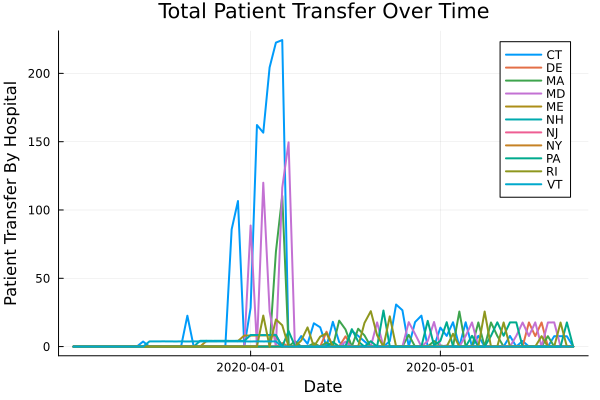

In [15]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

#start_date = Date(2020, 3, 30)
#end_date   = Date(2020, 4, 12)
date_range = start_date:end_date

df = results.complete_table
cleaned_df = DataFrame(State=df.location, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, T)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# check the shortage matrix
#size(shortage_matrix)


plot(date_range, [vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Patient Transfer By Hospital",
     title = "Total Patient Transfer Over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
#savefig(joinpath("../figures", "PNAnew_PSent_plot304-522.png"))

store the patient sent data at each time horizon

In [54]:
sentp_matrix1 = sent_matrix

11×80 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0      0.0      0.0      …   0.0      0.0      0.0      0.0      25.3265   0.0       0.0      17.6265    0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0      0.0      0.0          0.0      0.0      0.0      0.0       0.0      7.62407   0.0       0.0       0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0      0.0      0.0          0.0      0.0      7.7425   7.68015   0.0      0.0       0.0       7.59349   0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0      0.0      0.0         25.5615   0.0      0.0      0.0       0.0      0.0       7.60682   0.0       7.58301  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0      0.0      0.0          0.0      0.0      0.0      0.0       0.0      0.0       0.0       0.0       0.0      0.0
 0.0  0.0  0.0  0.0  0.0  0

store cumulative patient sent at each time horizon

In [55]:
cumulative_sent1 = vec(sum(sentp_matrix1, dims = 1))
# cumulative_sent2 = vec(sum(sentp_matrix2, dims = 1))

80-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  3.7847700119018555
  ⋮
 25.58154699471767
 25.509353549792355
 25.561492129485174
 21.74319637846034
 25.42272696440501
 25.41341740017389
 25.326463252111296
 25.274602401732494
 25.314775507871403
 25.219993516795817
 25.283081689173876
  0.0

In [56]:
pTransfer = DataFrame(date = date_range, patient = cumulative_sent1)
using CSV
CSV.write("../data output/PNAnewPtransfer304-522.csv",pTransfer)

"../data output/PNAnewPtransfer304-522.csv"

## Shortage Plots

Plot shortage over time using patient-nurse allocaiton model

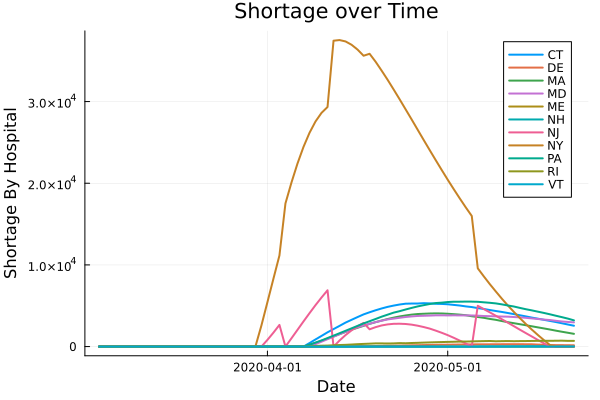

In [16]:
# start_date = Date(2020, 3, 30)
# end_date   = Date(2020, 4, 12)
date_range = start_date:end_date
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)
df = results_nurses.complete_table
cleaned_df = DataFrame(State=df.state, Date=df.date, Shortage=df.shortage)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
shortage_matrix = zeros(11, T)
for (i, state_df) in enumerate(grouped_df)
    shortage_matrix[i, :] .= state_df.Shortage
end

# check the shortage matrix
#size(shortage_matrix)

net_shortage = shortage_matrix

plot(date_range, [vec(net_shortage[i,:]) for i in 1:size(net_shortage)[1]],
     xlabel = "Date",
     ylabel = "Shortage By Hospital",
     title = "Shortage over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
#savefig(joinpath("../figures", "PNAnew_shortage_plot304-522.png"))
     

Store shortage matrix by state

In [60]:
shortage_matrix1 = shortage_matrix

11×80 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  3352.72         3163.52         3021.49         2881.38   2706.15     2568.99
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      169.976         168.65          152.927         151.837   150.802     143.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2161.63         2034.48         1910.38         1782.16   1646.49     1520.39
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     3342.5          3286.19         3221.98         3154.56   3090.18     3022.9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0             0.0             0.0             0.0       0.0         0.0
 0.0  0.0  0.0  0.0 

In [24]:
df = DataFrame(permutedims(shortage_matrix), :auto)

# Add column names
columns = ["Column_$i" for i in 1:length(states)]
rename!(df, states)

show(df, allcols=true)

using Statistics
describe(df)
using CSV
CSV.write("../data output/DSstatePNAShortage.csv",describe(df))

80×11 DataFrame
 Row │ CT       DE       MA       MD       ME           NH       NJ        NY        PA       RI       VT          
     │ Float64  Float64  Float64  Float64  Float64      Float64  Float64   Float64   Float64  Float64  Float64     
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │    0.0     0.0       0.0      0.0   0.0           0.0        0.0       0.0       0.0     0.0    0.0
   2 │    0.0     0.0       0.0      0.0   0.0           0.0        0.0       0.0       0.0     0.0    0.0
   3 │    0.0     0.0       0.0      0.0   0.0           0.0        0.0       0.0       0.0     0.0    0.0
   4 │    0.0     0.0       0.0      0.0   0.0           0.0        0.0       0.0       0.0     0.0    0.0
   5 │    0.0     0.0       0.0      0.0   0.0           0.0        0.0       0.0       0.0     0.0    0.0
   6 │    0.0     0.0       0.0      0.0   0.0           0.0        0.0       0.0       0.0     0.0  

"../data output/DSstatePNAShortage.csv"

Store cumulative shortage over time

In [26]:
cumulative_shortage1 = vec(sum(shortage_matrix, dims = 1))

80-element Vector{Float64}:
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     ⋮
 24772.40334785034
 23120.38955739525
 21458.627532183815
 19834.565163478615
 18243.069167286794
 16649.521649630544
 15111.173136011148
 13581.930891899377
 12833.880393425792
 12300.900923258356
 11752.444801768625
 11204.826889940987

In [27]:
net_shortage = DataFrame(date = date_range, shortage = cumulative_shortage1)
using CSV
#CSV.write("../data output/PNAnewShortage304-522.csv",net_shortage)

In [30]:
describe(net_shortage.shortage)


Length = 80
Mean = 21577.603304
Std_Deviation = 19596.943752
Minimum =0.000000
first_Quartile = 0.000000
Median = 19038.817165
third_Quartile = 41068.693182
Maximum = 51549.636339


# Create DataFrame
df_summary_overallshortage = DataFrame(
    Statistic = ["Length", "Mean", "Std. Deviation", "Minimum", "1st Quartile", "Median", "3rd Quartile", "Maximum"],
    Value = [Length, Mean, Std_Deviation, Minimum, first_Quartile, Median, third_Quartile, Maximum]
)

# Show DataFrame
show(df_summary_overallshortage, allrows=true)

using CSV
CSV.write("../data output/DSPNAOverallShortage.csv",df_summary_overallshortage)


Summary Stats:
Length:         80
Missing Count:  0
Mean:           21577.603304
Std. Deviation: 19596.943752
Minimum:        0.000000
1st Quartile:   0.000000
Median:         19038.817165
3rd Quartile:   41068.693182
Maximum:        51549.636339
Type:           Float64
8×2 DataFrame
 Row │ Statistic       Value   
     │ String          Float64 
─────┼─────────────────────────
   1 │ Length             80.0
   2 │ Mean            21577.6
   3 │ Std. Deviation  19596.9
   4 │ Minimum             0.0
   5 │ 1st Quartile        0.0
   6 │ Median          19038.8
   7 │ 3rd Quartile    41068.7
   8 │ Maximum         51549.6

"../data output/DSPNAOverallShortage.csv"

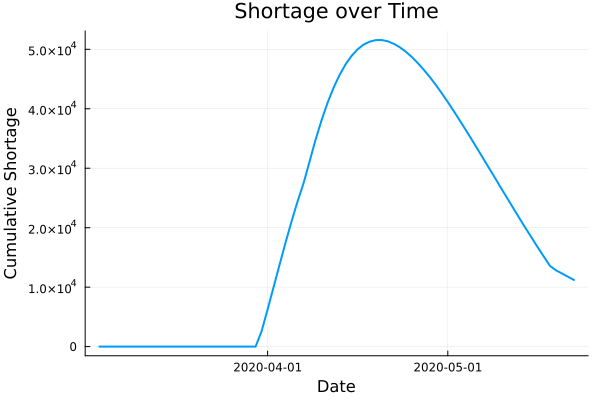

In [63]:
gr()
plot(date_range, cumulative_shortage1,
     xlabel = "Date",
     ylabel = "Cumulative Shortage",
     title = "Shortage over Time",
     legend = false,
     linewidth = 2,fmt=:png) 
#savefig(joinpath("../figures", "PNA_shortage_plot224-524.png"))    

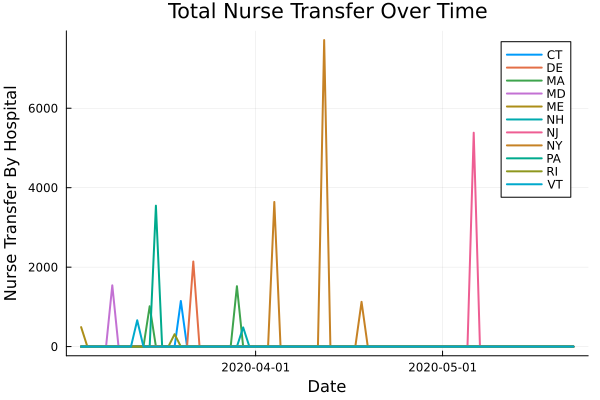

In [33]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
states_cleaned = [replace(state, r"[, ]" => "") for state in states]
states_cleaned_row = hcat(states_cleaned...)

df = results_nurses.complete_table
cleaned_df = DataFrame(State=df.state, Date=df.date, Sent=df.sent)
# Group by state and date, then create the 11x93 matrix
grouped_df = groupby(cleaned_df, :State)
sent_matrix = zeros(11, T)
for (i, state_df) in enumerate(grouped_df)
    sent_matrix[i, :] .= state_df.Sent
end

# check the shortage matrix
#size(shortage_matrix)

plot(date_range, [vec(sent_matrix[i,:]) for i in 1:size(sent_matrix)[1]],
     xlabel = "Date",
     ylabel = "Nurse Transfer By Hospital",
     title = "Total Nurse Transfer Over Time",
     legend = :topright,
     label = states_cleaned_row,
     linewidth = 2,
     fmt=:png)
#savefig(joinpath("../figures", "PNAnew_NSent_plot304-522.png"))

Store nurse transfer by state

In [35]:
sentn_matrix1 = sent_matrix

11×80 Matrix{Float64}:
   0.0  0.0  0.0  0.0  0.0     0.0   0.0  0.0  0.0    0.0   0.0     0.0      0.0   0.0  0.0    0.0   …  0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0  0.0  0.0  0.0  0.0     0.0   0.0  0.0  0.0    0.0   0.0     0.0      0.0   0.0  0.0    0.0      0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0  0.0  0.0  0.0  0.0     0.0   0.0  0.0  0.0    0.0   0.0  1016.14     0.0   0.0  0.0    0.0      0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0  0.0  0.0  0.0  0.0  1542.25  0.0  0.0  0.0    0.0   0.0     0.0      0.0   0.0  0.0    0.0      0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 490.5  0.0  0.0  0.0  0.0     0.0   0.0  0.0  0.0    0.0   0.0     0.0      0.0   0.0  0.0    0.0      0.0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [37]:
df = DataFrame(permutedims(sentn_matrix1), :auto)

# Add column names
columns = ["Column_$i" for i in 1:length(states)]
rename!(df, states)

show(df, allcols=true)

using Statistics
describe(df)
using CSV
CSV.write("../data output/DSstatePNASent.csv",describe(df))

80×11 DataFrame
 Row │ CT       DE       MA       MD       ME       NH       NJ       NY       PA       RI       VT      
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     0.0      0.0     0.0      0.0     490.5      0.0      0.0      0.0     0.0       0.0     0.0
   2 │     0.0      0.0     0.0      0.0       0.0      0.0      0.0      0.0     0.0       0.0     0.0
   3 │     0.0      0.0     0.0      0.0       0.0      0.0      0.0      0.0     0.0       0.0     0.0
   4 │     0.0      0.0     0.0      0.0       0.0      0.0      0.0      0.0     0.0       0.0     0.0
   5 │     0.0      0.0     0.0      0.0       0.0      0.0      0.0      0.0     0.0       0.0     0.0
   6 │     0.0      0.0     0.0   1542.25      0.0      0.0      0.0      0.0     0.0       0.0     0.0
   7 │     0.0      0.0     0.0      0.0  

"../data output/DSstatePNASent.csv"

store nurse transfer over time

In [38]:
cumulative_sentn_1 = vec(sum(sentn_matrix1, dims = 1))

80-element Vector{Float64}:
  490.5
    0.0
    0.0
    0.0
    0.0
 1542.25
    0.0
    0.0
    0.0
  663.25
    0.0
 1016.1428887298807
 3547.25
    ⋮
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0
    0.0

In [40]:
sent_overall = DataFrame(date = date_range, sent = cumulative_sentn_1)
describe(sent_overall.sent)

# Summary statistics

Length = 80
Mean =  384.172150
Std_Deviation = 1214.141544
Minimum = 0.000000
first_Quartile = 0.000000
Median = 0.000000
third_Quartile = 0.000000
Maximum = 7715.555021



# Create DataFrame
df_summary_overallsent = DataFrame(
    Statistic = ["Length", "Mean", "Std. Deviation", "Minimum", "1st Quartile", "Median", "3rd Quartile", "Maximum"],
    Value = [Length, Mean, Std_Deviation, Minimum, first_Quartile, Median, third_Quartile, Maximum]
)

# Show DataFrame
show(df_summary_overallsent, allrows=true)

using CSV
CSV.write("../data output/DSOverallNAsent.csv",df_summary_overallsent)



Summary Stats:
Length:         80
Missing Count:  0
Mean:           384.172150
Std. Deviation: 1214.141544
Minimum:        0.000000
1st Quartile:   0.000000
Median:         0.000000
3rd Quartile:   0.000000
Maximum:        7715.555021
Type:           Float64
8×2 DataFrame
 Row │ Statistic       Value    
     │ String          Float64  
─────┼──────────────────────────
   1 │ Length            80.0
   2 │ Mean             384.172
   3 │ Std. Deviation  1214.14
   4 │ Minimum            0.0
   5 │ 1st Quartile       0.0
   6 │ Median             0.0
   7 │ 3rd Quartile       0.0
   8 │ Maximum         7715.56

"../data output/DSOverallNAsent.csv"

In [68]:
nurseTransfer = DataFrame(date = date_range, nurses = cumulative_sentn_1)
using CSV
CSV.write("../data output/PNAnewNtransfer304-522.csv",nurseTransfer)

"../data output/PNAnewNtransfer304-522.csv"

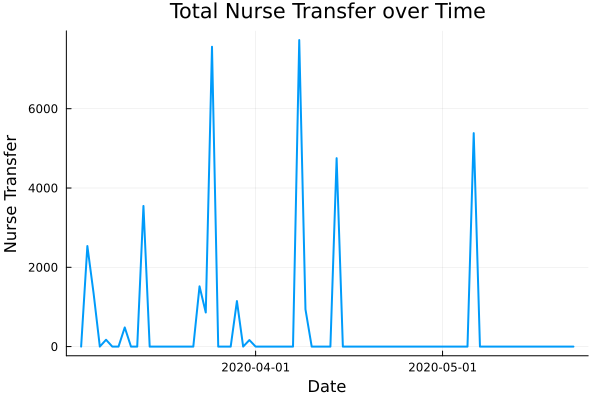

In [69]:
gr()
plot(date_range, cumulative_sentn_1,
     xlabel = "Date",
     ylabel = "Nurse Transfer",
     title = "Total Nurse Transfer over Time",
     legend = false,
     linewidth = 2,fmt=:png) 